In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from models.Pix2Pix_youtube import Pix2PixGAN
from utils.Dataset import *
from utils.lossTracker import save_losses, load_losses
import matplotlib.gridspec as gridspec
from utils.ConfigLoader import ConfigLoader
config = ConfigLoader()

# Получаем 5 первых изображений из тренировочного загрузчика
train_iterator = iter(train_loader)  # Создаем итератор для train_loader
fixed_batch = next(train_iterator)  # Получаем первый batch
fixed_sar, fixed_optical = fixed_batch[0][:5], fixed_batch[1][:5]  # Берем 5 первых изображений

@torch.no_grad()
def save_training_images(model, epoch, g_loss, d_loss, save_dir):
    """
    Сохраняет графики генератора/дискриминатора потерь и фиксированные пять изображений.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Генерация фиксированных изображений
    generated = model.generator(fixed_sar.to(device))

    fig = plt.figure(figsize=(15, 40))
    gs = gridspec.GridSpec(7, 3, figure=fig)

    fig.suptitle(f"Epoch: {epoch+1}, G lr: {model.optimizer_D.param_groups[0]['lr']}, D lr: {model.optimizer_G.param_groups[0]['lr']}", fontsize=16)  # y задает отступ сверху

    # График потерь генератора
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(range(1, len(g_loss) + 1), g_loss, label="Generator Loss", color="blue")
    ax1.set_title("Generator Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()

    # График потерь дискриминатора
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(range(1, len(d_loss) + 1), d_loss, label="Discriminator Loss", color="red")
    ax2.set_title("Discriminator Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.grid()
    ax2.legend()

    # Добавляем изображения: SAR, Generated, Target
    for i in range(5):
        # SAR Image
        ax_sar = fig.add_subplot(gs[2 + i, 0])
        sar_image = fixed_sar[i, 0, :, :].cpu().detach().numpy()
        ax_sar.imshow(sar_image * 0.5 + 0.5, cmap='gray')
        ax_sar.set_title(f"SAR Image {i+1}")
        ax_sar.axis('off')

        # Generated Image
        ax_gen = fig.add_subplot(gs[2 + i, 1])
        generated_image = generated[i].permute(1, 2, 0).cpu().detach().numpy()
        ax_gen.imshow((generated_image * 0.5 + 0.5))
        ax_gen.set_title(f"Generated Image {i+1}")
        ax_gen.axis('off')

        # Target Image
        ax_opt = fig.add_subplot(gs[2 + i, 2])
        optical_image = fixed_optical[i].permute(1, 2, 0).cpu().detach().numpy()
        ax_opt.imshow((optical_image * 0.5 + 0.5))
        ax_opt.set_title(f"Target Image {i+1}")
        ax_opt.axis('off')

    # Настройка расстояний между элементами
    plt.tight_layout()

    # Сохранение итогового изображения
    save_path = os.path.join(save_dir, f"epoch_{epoch+1}_images.png")
    plt.savefig(save_path)
    plt.close(fig)


# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f'Using {device}')
torch.cuda.empty_cache() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.mps.is_available() else None

# Создание модели
model = Pix2PixGAN(device)

# Загрузка модели
if config.get('model', 'load_model'):
    start_epoch = model.load_state('checkpoint_epoch_400', device)
    losses_dict = load_losses()
    if losses_dict:
        g_loss = losses_dict['g_loss']
        d_loss = losses_dict['d_loss']
else:
    start_epoch = 0
    g_loss = []
    d_loss = []

# Конечная эпоха
end_epoch = config.get('model', 'end_epoch')
torch.backends.cudnn.benchmark = True

# Обучение модели
for epoch in range(start_epoch, end_epoch):
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{end_epoch}", leave=False) as pbar:
        epoch_loss_G, epoch_loss_D = [], []
        for real_A, real_B in pbar:
            loss_D, loss_G = model.train_step(real_A.to(device), real_B.to(device))
            pbar.set_postfix({
                "Loss D": loss_D,
                "Loss G": loss_G,
                "LR D": model.optimizer_D.param_groups[0]['lr'],
                "LR G": model.optimizer_G.param_groups[0]['lr']
            })
            epoch_loss_G.append(loss_G)
            epoch_loss_D.append(loss_D)

        # Адаптация скорости обучения
        model.step_schedulers(np.mean(epoch_loss_G), np.mean(epoch_loss_D))

        g_loss.append(loss_G)
        d_loss.append(loss_D)

        # Сохранение модели и метрик
        if (epoch + 1) % 100 == 0:
            model.save_state(epoch, save_dir=config.get('paths', 'model_save_dir'))
            save_losses(g_loss=g_loss, d_loss=d_loss)

        # Сохранение изображений каждые 20 эпох
        if (epoch + 1) % 20 == 0:
            save_training_images(model, epoch, g_loss, d_loss, save_dir=config.get('paths', 'image_save_dir'))


Using mps


Epoch 1/400:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2/400:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3/400:   0%|          | 0/91 [00:00<?, ?it/s]

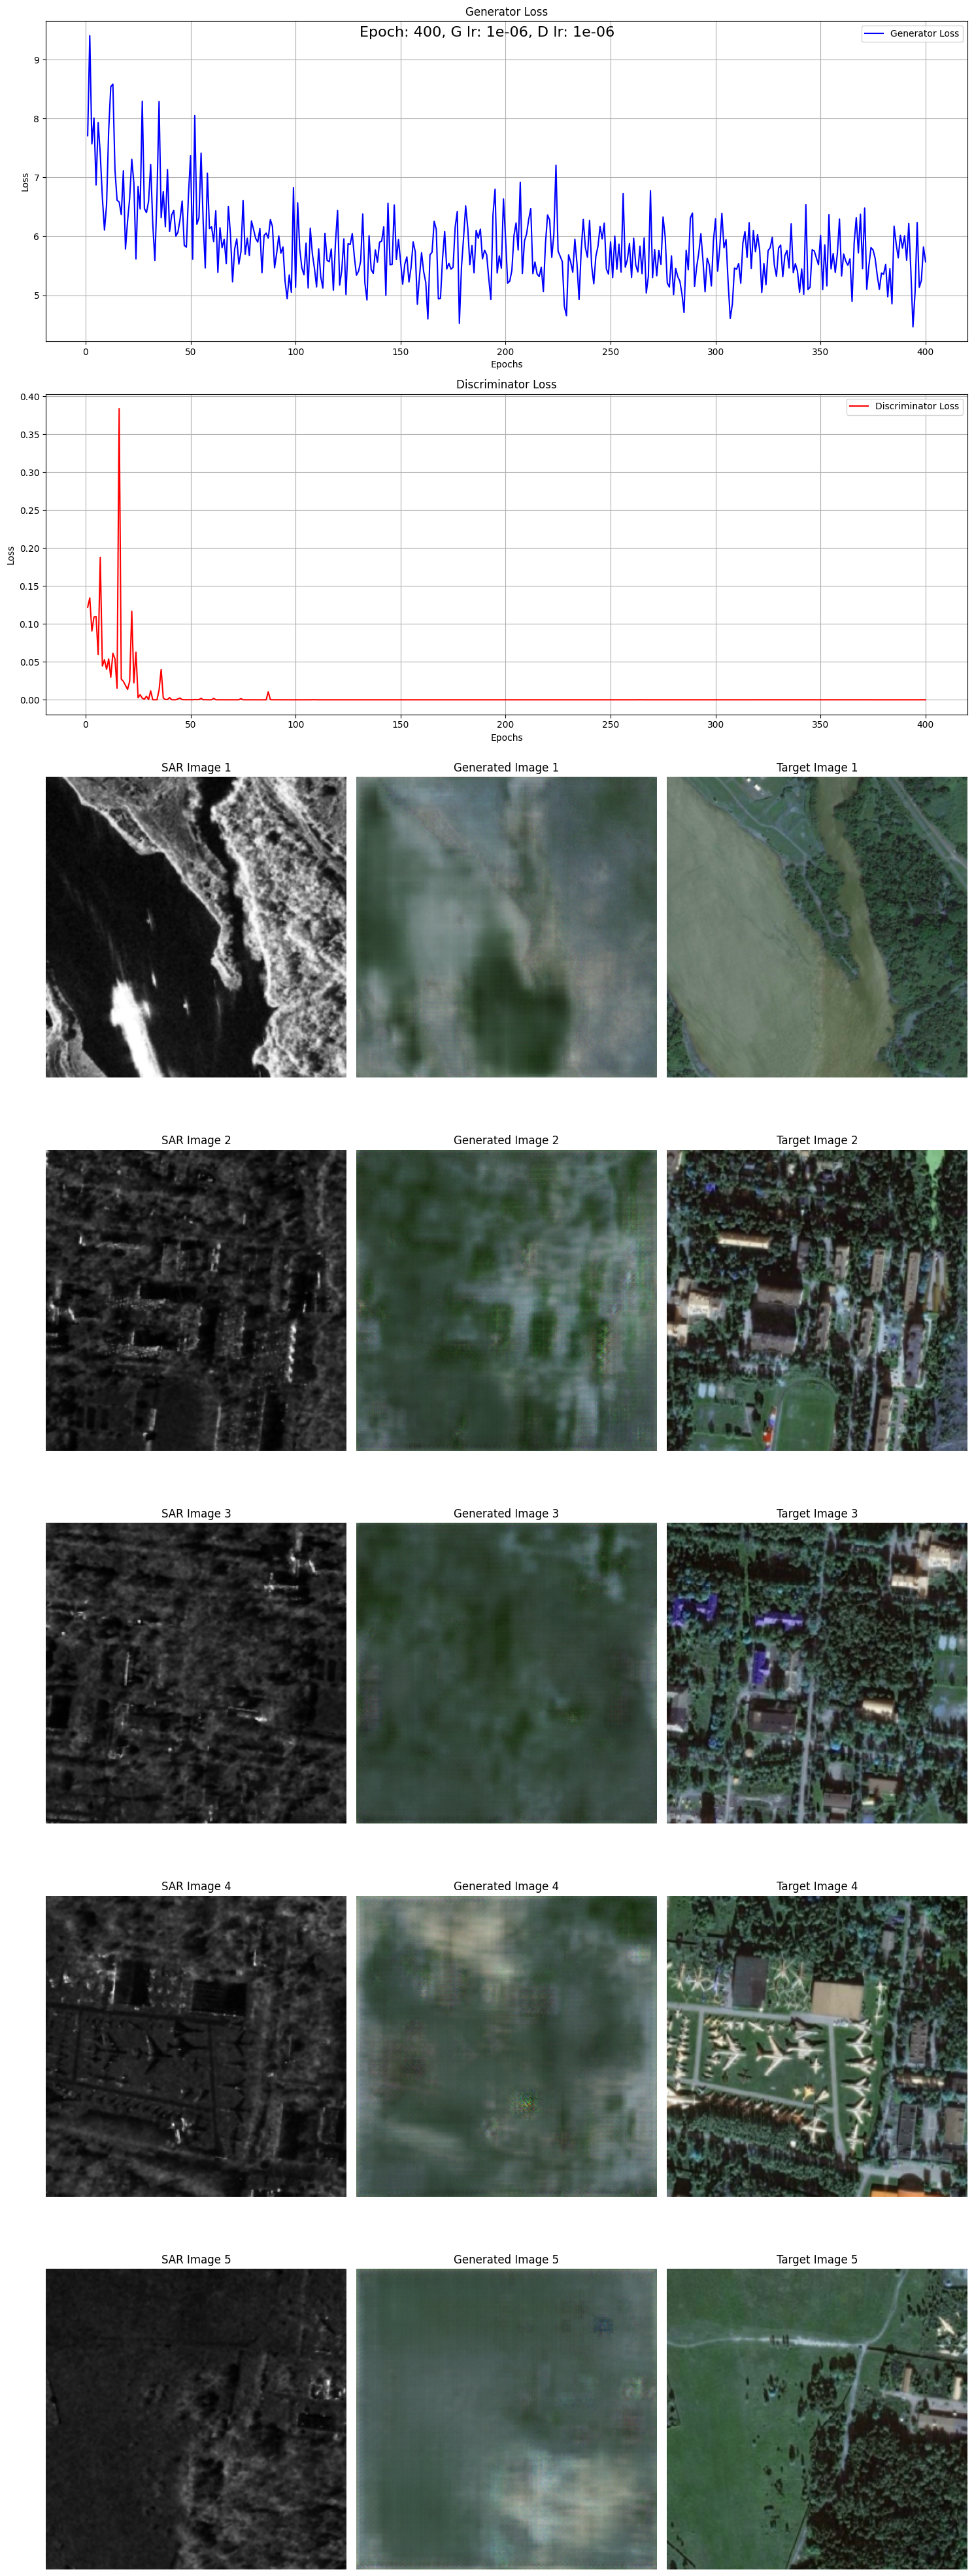

In [2]:
@torch.no_grad()
def show_test_images(model, epoch, g_loss, d_loss):
    """
    Сохраняет графики генератора/дискриминатора потерь и фиксированные пять изображений.
    """

    fig = plt.figure(figsize=(15, 40))
    gs = gridspec.GridSpec(7, 3, figure=fig)

    fig.suptitle(f"Epoch: {epoch+1}, G lr: {model.optimizer_D.param_groups[0]['lr']}, D lr: {model.optimizer_G.param_groups[0]['lr']}", fontsize=16)  # y задает отступ сверху

    # График потерь генератора
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(range(1, len(g_loss) + 1), g_loss, label="Generator Loss", color="blue")
    ax1.set_title("Generator Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()

    # График потерь дискриминатора
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(range(1, len(d_loss) + 1), d_loss, label="Discriminator Loss", color="red")
    ax2.set_title("Discriminator Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.grid()
    ax2.legend()

    # Добавляем изображения: SAR, Generated, Target
    for i, (sar, opt) in enumerate(test_loader):
        if i >= 5:
            break
        # SAR Image
        gen = model.generator(sar.to(device))

        ax_sar = fig.add_subplot(gs[2 + i, 0])
        sar_image = sar[i, 0, :, :].cpu().detach().numpy()
        ax_sar.imshow(sar_image * 0.5 + 0.5, cmap='gray')
        ax_sar.set_title(f"SAR Image {i+1}")
        ax_sar.axis('off')

        # Generated Image
        ax_gen = fig.add_subplot(gs[2 + i, 1])
        generated_image = gen[i].permute(1, 2, 0).cpu().detach().numpy()
        ax_gen.imshow((generated_image * 0.5 + 0.5))
        ax_gen.set_title(f"Generated Image {i+1}")
        ax_gen.axis('off')

        # Target Image
        ax_opt = fig.add_subplot(gs[2 + i, 2])
        optical_image = opt[i].permute(1, 2, 0).cpu().detach().numpy()
        ax_opt.imshow((optical_image * 0.5 + 0.5))
        ax_opt.set_title(f"Target Image {i+1}")
        ax_opt.axis('off')

    # Настройка расстояний между элементами
    plt.tight_layout()

    # Сохранение итогового изображения
    # save_path = os.path.join(save_dir, f"epoch_{epoch+1}_images.png")
    # plt.savefig(save_path)
    plt.show()

show_test_images(model, epoch, g_loss, d_loss)